<a href="https://colab.research.google.com/github/tateemma/triangle-algorithm/blob/master/Final_Triangle_algorithm_using_corner_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

# Install libraries for SIFT and SURF

In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

 # take kp coordinates and put them in a list

In [0]:
def enlist(kp):
  points = []
  for point in kp:
    points.append((point.pt)) #you can put in array and normalise at the same time if you want
  points = np.array(points) #array is easier to work with
  return points

# remove points closer than $\epsilon$ 

In [0]:
def remove_close_pts(points):
  tbd = [] #to be deleted
  for i in range(len(points)):
    for j in range(i+1,len(points)):
      distance = np.sqrt((points[i][0]-points[j][0])**2 + (points[i][1]-points[j][1])**2)
      if  distance <= epsilon * 3:
        tbd.append(j)
  pnts = np.delete(points, tbd, 0) #remove 1 of the points from the list (axis = 0 bcoz toda kubvisa points[i] wc is axis = 0)
  return pnts

# sort them so that they are in order of size

In [0]:
#function to calculate distance between 2 points
def dist(p1,p2):
  result = np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
  return result

In [0]:
#define an edge with vertices p1 and p2, and length
class edge:
  def __init__(self, p1, p2):
    self.p1 = list(p1)
    self.p2 = list(p2)
    self.length = dist(p1,p2)

In [0]:
#function to rearrange. 
def rearrange(triangle):
  e1 = edge(triangle[0],triangle[1]) #triangle edges
  e2 = edge(triangle[1],triangle[2])
  e3 = edge(triangle[2],triangle[0])
  edges = [e1,e2,e3]
  s = sorted(edges, key=lambda e: e.length) #sort edges according to length
  '''
  now, each edge has 2 nodes. we must rearrange the nodes such that from v1 to v2 -> shortest length,
  v2 to v3 -> intermediate and v3 to v1 -> longest.
  If we have p1 to p3 as shortest, p2 to p3 as intermediate and p1 to p2 as longest, we have to find a way of selecting the nodes 
  so that we obtain the order p1-p3-p2.
  one way is from p1 to p3 and p2 to p3, we pick the one in the first pair that is not common to both points as the first node, then  
  from p2 to p3 and p1 to p2, we also pick the one in the first pair that is not common to both points as the next node and same for 
  the last one.
  '''
  if s[0].p1 == s[1].p1 or s[0].p1 == s[1].p2: #if s[0]p1 is in s[1], take the other point as v0
    v0 = s[0].p2
  else:
    v0 = s[0].p1
  if s[1].p1 == s[2].p1 or s[1].p1 == s[2].p2: 
    v1 = s[1].p2
  else:
    v1 = s[1].p1
  if s[2].p1 == s[0].p1 or s[2].p1 == s[0].p2:
    v2 = s[2].p2
  else:
    v2 = s[2].p1
  result = (v0,v1,v2)
  return result

# Get R, C, $t_R$, $t_C$, log p, s and orientation

In [0]:
#find r_3 max
def r3_max(t_list):
  r3s = []
  for tri in t_list:
    r3s.append(dist(tri[2],tri[0]))
  result = max(r3s)
  return result

In [0]:
# define an object - a triangle with parameters
class tri_with_params:
  def __init__(self, triangle):
    self.triangle = triangle
    self.p1 = triangle[0]
    self.p2 = triangle[1]
    self.p3 = triangle[2]
    self.r1 = edge(self.p1, self.p2)
    self.r2 = edge(self.p2, self.p3)
    self.r3 = edge(self.p3, self.p1)
  
  def R(self):
    R = self.r3.length / self.r1.length
    return R

  def logp(self):
    logp = np.log(self.r1.length + self.r2.length + self.r3.length)
    return logp

  def s(self, r3max):
    s = self.r3.length / r3max
    return s

  def C(self):
    C = (1/(self.r3.length*self.r1.length))*(((self.p3[0]-self.p1[0])*(self.p2[0]-self.p1[0]))+((self.p3[1]-self.p1[1])*(self.p2[1]-self.p1[1])))
    return C

  def F(self):
    F = (epsilon**2)*((1/(self.r3.length**2))-(self.C()/(self.r3.length*self.r1.length))+(1/(self.r1.length**2)))
    return F

  def tR_sqrd(self):
    tR_sqrd = 2 * (self.R()**2) * self.F()
    return tR_sqrd

  def tC_sqrd(self):
    q = (1/2)*(self.r1.length + self.r2.length + self.r3.length)
    A = np.sqrt(q*(q-self.r1.length)*(q-self.r2.length)*(q-self.r3.length))
    S = (2*A)/(self.r3.length*self.r1.length)
    tC_sqrd = (2 * (S**2) * self.F()) + (3 * (self.C()**2) * (self.F()**2))
    return tC_sqrd

  def theta(self): #theta should be in degrees, this is in radians
    x_c = (1/3)*(self.p1[0] + self.p2[0] + self.p3[0])
    y_c = (1/3)*(self.p1[1] + self.p2[1] + self.p3[1])
    theta = np.arctan((self.p1[1]-y_c)/(self.p1[0]-x_c))
    return theta
  

# Store in dataframe

In [0]:
def create_df(triangles_list):
  rows = []
  r3max = r3_max(triangles_list)
  for i in triangles_list:
    tp = tri_with_params(i)
    rows.append([tp.triangle, tp.R(), tp.C(), tp.logp(), tp.s(r3max), tp.tR_sqrd(), tp.tC_sqrd(), tp.theta()])
  df = pd.DataFrame(rows, columns=['triangle', 'R', 'C', 'logp', 's', 'tR_sqrd', 'tC_sqrd', 'theta'])
  return df

# Filter triangles with $s > s_{max} (= 0.85)$ and $C > 0.99$

In [0]:
def clean_triangles(dataframe):
  dataframe = dataframe.drop(dataframe[dataframe['R'] > 8].index).reset_index(drop=True)
  dataframe = dataframe.drop(dataframe[dataframe['s'] > 0.85].index).reset_index(drop=True)
  dataframe = dataframe.drop(dataframe[dataframe['C'] > 0.99].index).reset_index(drop=True)
  return dataframe

# Match triangles
For triangles in two lists A and B, they are compared using their R, $\theta$ and C values. If 
\begin{equation}
(R_A - R_B)^2 < t_{R_A}^2 + t_{R_B}^2,
\end{equation}
\begin{equation}
(C_A - C_B)^2 < t_{C_A}^2 + t_{C_B}^2
\end{equation}
and
\begin{equation}
\theta_A - \theta_B < \theta_{max}
\end{equation}
where $\theta_{max}$ is user selected, then two triangles are a match.

The relative magnification factor M is also computed,
\begin{equation}
log M = log p_A - log p_B
\end{equation}


If more than 1 triangle from list B matches a triangle in list A, the one with the smallest $\delta$ is retained, where
\begin{equation}
\delta^2 = \frac{(R_A - R_B)^2}{t_{R_A}^2 + t_{R_B}^2} + \frac{(C_A - C_B)^2}{t_{C_A}^2 + t_{C_B}^2} + \frac{(\theta_A - \theta_B)^2}{\theta_{max}^2}
\end{equation}


In [0]:
#function to remove those that do not meet the first three equations.
def match(df):
  theta_max = 0.174533 #10 degrees in radians
  df = df.drop(df[df['r'] > df['tr2']].index).reset_index(drop=True)
  df = df.drop(df[df['c'] > df['tc2']].index).reset_index(drop=True)
  df = df.drop(df[df['theta'] > theta_max].index).reset_index(drop=True)
  return df

In [0]:
def filter_and_match(a): #function to calculate LHS and RHS of the eqns and store them in a df. Faster than a loop
  atris = pd.Series([a['triangle']]*len(dfB))
  atris = pd.DataFrame(atris, columns=['atriangle'])
 
  btris = list(dfB['triangle'])
  btris = pd.Series(btris)
  btris = pd.DataFrame(btris, columns=['btriangle'])
  
  r = (a['R']-dfB['R'])**2
  r = list(r)
  r = pd.Series(r)
  r = pd.DataFrame(r, columns=['r'])
  
  tr2 = (a['tR_sqrd']+dfB['tR_sqrd'])
  tr2 = list(tr2)
  tr2 = pd.Series(tr2)
  tr2 = pd.DataFrame(tr2, columns=['tr2'])

  c = (a['C']-dfB['C'])**2
  c = list(c)
  c = pd.Series(c)
  c = pd.DataFrame(c, columns=['c'])

  tc2 = (a['tC_sqrd']+dfB['tC_sqrd'])
  tc2 = list(tc2)
  tc2 = pd.Series(tc2)
  tc2 = pd.DataFrame(tc2, columns=['tc2'])

  theta = a['theta']-dfB['theta']
  theta = list(theta)
  theta = pd.Series(theta)
  theta = pd.DataFrame(theta, columns=['theta'])

  logM = a['logp'] - dfB['logp']
  logM = list(logM)
  logM = pd.Series(logM)
  logM = pd.DataFrame(logM, columns=['logM'])

  result = pd.concat([atris, btris, r, tr2, c, tc2, theta, logM], axis=1, sort=False) 

  #calculate delta
  theta_max = 0.174533 #10 degrees in radians
  result['delta'] = np.sqrt((result['r']/result['tr2']) + (result['c']/result['tc2']) + ((result['theta']**2)/(theta_max**2)))

  #remove those that do not meet the equations' conditions
  result = match(result) 
  
  #keep only one triangle with the smallest delta
  result = result[result['delta'] == result['delta'].min()]
  return result

The algorithm tracks $n_-$ matches by applying an iterative filter on $logM$. In each iteration, the mean and standard deviation of $logM$ values are computed for same sense triangles and matches are discarded if they receive magnifications more than $z$ standard deviations from the mean value, where

\begin{equation}
z = 
\begin{cases}
1, \text{ if } n_- > n_+ \\
3, \text{ if } m_F < 0.5m_T\\
2, \text{ otherwise }\\
\end{cases}
\end{equation}

We use $z = 2$ in our case.

# Final algorithm 

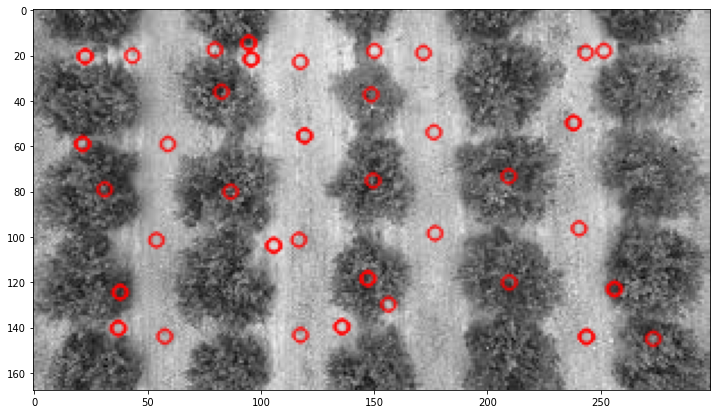

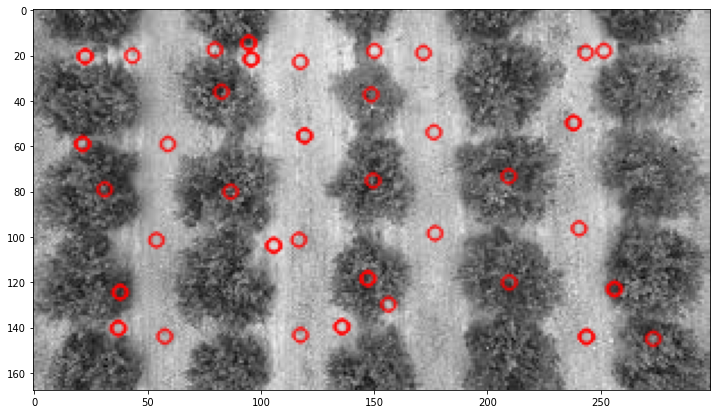

(<matplotlib.image.AxesImage at 0x7f8074e9b3c8>, None)

In [0]:
img1 = cv2.imread('/content/drive/My Drive/citrus5.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/drive/My Drive/citrus5.jpeg', cv2.IMREAD_GRAYSCALE)

# Create SIFF object. 
sift = cv2.xfeatures2d.SIFT_create(nfeatures=50) 

# Find keypoints and descriptors directly
kp1, des1 = sift.detectAndCompute(img1, None) 
kp2, des2 = sift.detectAndCompute(img2, None) 

img1_pt = cv2.drawKeypoints(img1,kp1,None,(255,0,0),2)
img2_pt = cv2.drawKeypoints(img2,kp2,None,(255,0,0),2)

plt.figure(figsize=(15,7))
plt.imshow(img1_pt),plt.show()
plt.figure(figsize=(15,7))
plt.imshow(img2_pt),plt.show()

In [0]:
len(kp1), len(kp2)

(50, 50)

In [0]:
global epsilon
epsilon = 0.0001

def triangle_algorithm(list1, list2):
  #put points in lists (array)
  listA = list1
  listB = list2

  #normalize
  listA = listA/listA.max() #normalize by dividing with the max value
  listB = listB/listB.max()

  #remove close points
  listA = remove_close_pts(listA)
  print('The number of points in list A is ', listA.shape)

  listB = remove_close_pts(listB)
  print('\n The number of points in list B is ', listB.shape)

  #create triangles
  A_triangles = it.combinations(listA, 3) # returns an object
  A_triangles = list(A_triangles) #change it to a list
  B_triangles = it.combinations(listB, 3) # returns an object
  B_triangles = list(B_triangles) #change it to a list

  #check sizes
  print('\n The number of triangles in list A is ', len(A_triangles))
  print('\n The number of triangles in list B is ', len(B_triangles))

  #rearrange triangles
  for i in range(len(A_triangles)):
    A_triangles[i] = rearrange(list(A_triangles[i]))

  for i in range(len(B_triangles)):
    B_triangles[i] = rearrange(list(B_triangles[i]))

  #find geometric attributes and store in dataframes
  print('\n Calculating geometric properties...')
  df_A = create_df(A_triangles)
  df_B = create_df(B_triangles)

  #filter triangles
  print('\n Filtering triangles...')
  dfA = clean_triangles(df_A)

  global dfB #we use dfB as input in clean_triangles, that's why it's global
  dfB = clean_triangles(df_B)

  #check sizes
  print('\n After filtering triangles, we have ', len(dfA), ' triangles in A and ', len(dfB), ' triangles in B')

  #match triangles
  print('\n Matching triangles...')
  filtered = dfA.apply(filter_and_match, axis=1) #call the function and store results in dataframe

  #We need to concatenate results into 1 dataframe
  matched = pd.DataFrame(columns=['atriangle', 'btriangle', 'r', 'tr2', 'c', 'tc2', 'theta', 'logM'])
  for i in range(len(filtered)):
    matched = pd.concat([matched, filtered[i]], ignore_index=True, sort=False)

  #check size
  print('\n There are ', len(matched), 'matched triangles')

  #histogram before filtering with logM
  plt.title("\n $logM$ DISTRIBUTION BEFORE FILTERING WITH THE $logM$ filter")
  matched['logM'].plot.hist()

  print("\n Filtering with logM values...")
  #iterations of logM values
  for i in range(20):
    avg_logM = matched['logM'].mean()
    std = matched['logM'].std()
    matched = matched.drop(matched[abs(matched['logM'] - avg_logM) > (std*2)].index).reset_index(drop=True) #std*5 or 1.5

  #check size
  print('\n After filtering with logM, we have ', len(matched), ' triangles')

  return matched

# run 1

The number of points in list A is  (37, 2)

 The number of points in list B is  (37, 2)

 The number of triangles in list A is  7770

 The number of triangles in list B is  7770

 Calculating geometric properties...

 Filtering triangles...

 After filtering triangles, we have  6629  triangles in A and  6629  triangles in B

 Matching triangles...

 There are  6629 matched triangles

 Filtering with logM values...

 After filtering with logM, we have  6629  triangles


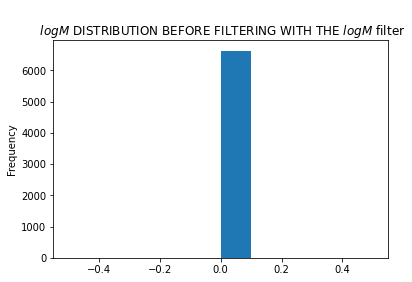

In [0]:
run1 = triangle_algorithm(enlist(kp1), enlist(kp2)) 

### vote and finalize

In [0]:
#extract vertices of each matched triangle for voting
listAnodes = pd.DataFrame(list(run1['atriangle']), columns=['v1', 'v2', 'v3'])

#concatenate the lists into 1 list
points = list(listAnodes['v1']) + list(listAnodes['v2']) + list(listAnodes['v3'])
Ap = pd.DataFrame(pd.Series(points), columns=['Apoints'])

In [0]:
#we want to select rows with the same points and count their score using groupby function

#preprocessing for groupby. Function works with tuples not lists, so we change the points to tuples
astuple = lambda x: (x[0][0],x[0][1])
Ap = Ap.apply(astuple, axis=1) 
Ap = pd.DataFrame(Ap, columns=['Ap'])

#groupby
Avotes = Ap.groupby('Ap').Ap.count()
Avotes = pd.DataFrame(Avotes)

#delete those with less than 2 votes
Avotes = Avotes.drop(Avotes[Avotes['Ap'] < 2].index)
len(Avotes)

37

In [0]:
#the same process for listB
listBnodes = pd.DataFrame(list(run1['btriangle']), columns=['v1', 'v2', 'v3'])
points = list(listBnodes['v1']) + list(listBnodes['v2']) + list(listBnodes['v3'])
Bp = pd.DataFrame(pd.Series(points), columns=['Bpoints'])

In [0]:
astuple = lambda x: (x[0][0],x[0][1])
Bp = Bp.apply(astuple, axis=1) 
Bp = pd.DataFrame(Bp, columns=['Bp'])
Bvotes = Bp.groupby('Bp').Bp.count()
Bvotes = pd.DataFrame(Bvotes)
Bvotes = Bvotes.drop(Bvotes[Bvotes['Bp'] < 2].index)
len(Bvotes)

37

In [0]:
#take the results from the shortest list
if len(Avotes) <= len(Bvotes):
  selected_list = sorted(Avotes['Ap'], reverse=True)
elif len(Bvotes) < len(Avotes):
  selected_list = sorted(Bvotes['Bp'], reverse=True)

In [0]:
#calculate the
score = 0
for i in range(len(selected_list)):
  if i == 0:
      score += selected_list[i]
  elif selected_list[i] < 0.5*selected_list[i-1]:
    break
  else:
    score += selected_list[i]

In [0]:
print(score)

19887


# run 2

In [0]:
kp3 = list(Avotes.index)
kp4 = list(Bvotes.index)

The number of points in list A is  (37, 2)

 The number of points in list B is  (37, 2)

 The number of triangles in list A is  7770

 The number of triangles in list B is  7770

 Calculating geometric properties...

 Filtering triangles...

 After filtering triangles, we have  6629  triangles in A and  6629  triangles in B

 Matching triangles...

 There are  6629 matched triangles

 Filtering with logM values...

 After filtering with logM, we have  6629  triangles


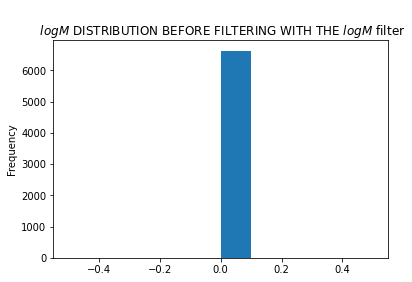

In [0]:
run2 = triangle_algorithm(np.array(kp3), np.array(kp4))

### vote and finalize

In [0]:
#extract vertices of each matched triangle for voting
listAnodes = pd.DataFrame(list(run2['atriangle']), columns=['v1', 'v2', 'v3'])

#concatenate the lists into 1 list
points = list(listAnodes['v1']) + list(listAnodes['v2']) + list(listAnodes['v3'])
Ap = pd.DataFrame(pd.Series(points), columns=['Apoints'])

In [0]:
#we want to select rows with the same points and count their score using groupby function

#preprocessing for groupby. Function works with tuples not lists, so we change the points to tuples
astuple = lambda x: (x[0][0],x[0][1])
Ap = Ap.apply(astuple, axis=1) 
Ap = pd.DataFrame(Ap, columns=['Ap'])

#groupby
Avotes = Ap.groupby('Ap').Ap.count()
Avotes = pd.DataFrame(Avotes)

#delete those with less than 2 votes
Avotes = Avotes.drop(Avotes[Avotes['Ap'] < 2].index)
len(Avotes)

37

In [0]:
#the same process for listB
listBnodes = pd.DataFrame(list(run1['btriangle']), columns=['v1', 'v2', 'v3'])
points = list(listBnodes['v1']) + list(listBnodes['v2']) + list(listBnodes['v3'])
Bp = pd.DataFrame(pd.Series(points), columns=['Bpoints'])

In [0]:
astuple = lambda x: (x[0][0],x[0][1])
Bp = Bp.apply(astuple, axis=1) 
Bp = pd.DataFrame(Bp, columns=['Bp'])
Bvotes = Bp.groupby('Bp').Bp.count()
Bvotes = pd.DataFrame(Bvotes)
Bvotes = Bvotes.drop(Bvotes[Bvotes['Bp'] < 2].index)
len(Bvotes)

37

In [0]:
#take the results from the shortest list
if len(Avotes) <= len(Bvotes):
  selected_list = sorted(Avotes['Ap'], reverse=True)
elif len(Bvotes) < len(Avotes):
  selected_list = sorted(Bvotes['Bp'], reverse=True)

In [0]:
#calculate the
score = 0
for i in range(len(selected_list)):
  if i == 0:
      score += selected_list[i]
  elif selected_list[i] < 0.5*selected_list[i-1]:
    break
  else:
    score += selected_list[i]

In [0]:
print(score)

19887
